# Parallel raster computations using Dask

Goal:
- Profile the timing of the raster calculations with median filter as case study.
- Open raster data as a chunked array.
- Recognize good practices in selecting proper chunk sizes.
- Setup raster calculations that take advantage of parallelization.

## Time Profiling

In [1]:
# Load search json
import pystac
items = pystac.ItemCollection.from_file("search.json")

In [ ]:
# Select assets from the last item
assets = items[-1].assets
# Get the visual asset href
visual_href = assets["visual"].href

In [3]:
# Open raster
import rioxarray
visual = rioxarray.open_rasterio(visual_href, overview_level=2)
print(visual.rio.resolution())

(79.97086671522214, -79.97086671522214)


In [4]:
# Load the data to memory
visual = visual.load()

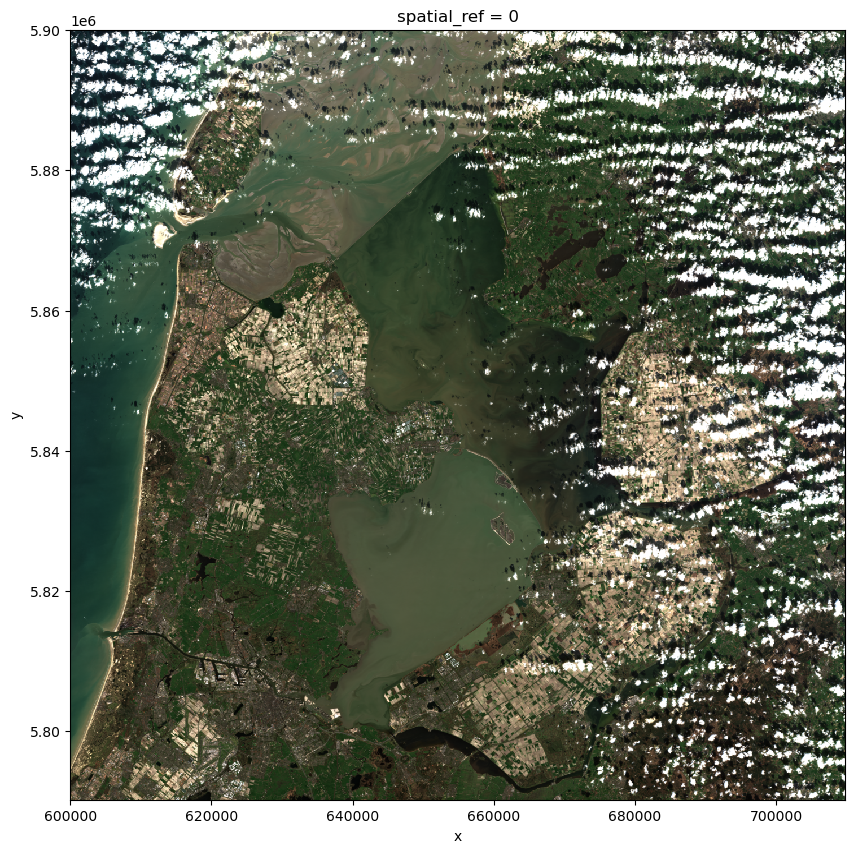

In [5]:
visual.plot.imshow(figsize=(10,10))

In [6]:
%%time
# Calculate median filter with 7x7 window
median = visual.rolling(x=7, y=7, center=True).median()

CPU times: user 7.25 s, sys: 2.39 s, total: 9.64 s
Wall time: 10.8 s


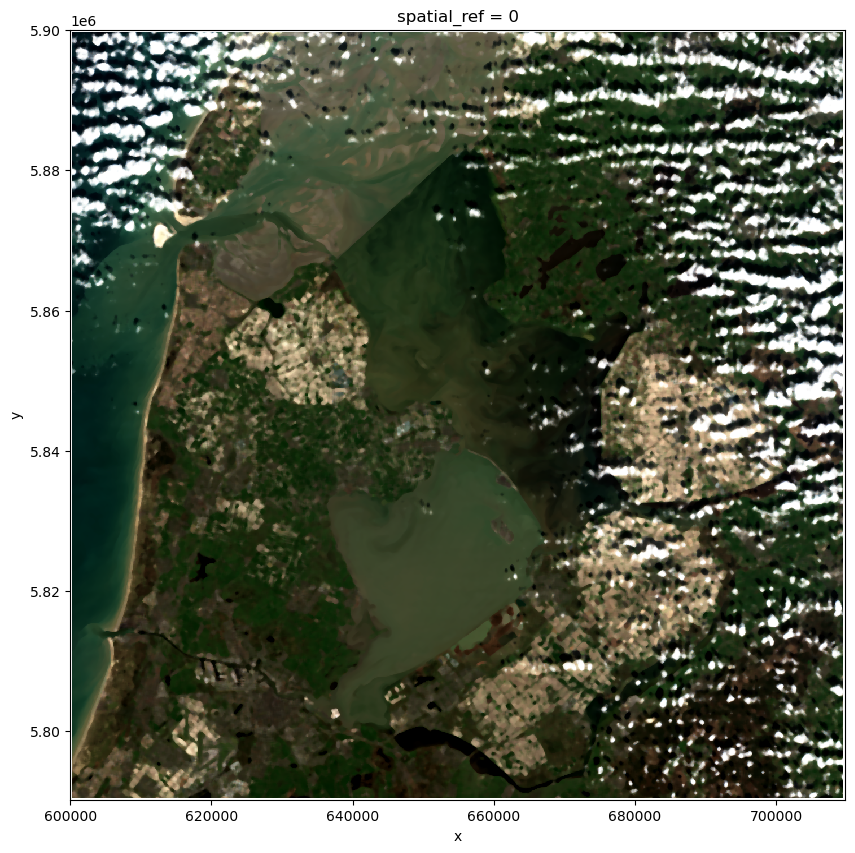

In [7]:
median.plot.imshow(robust=True, figsize=(10,10))

In [8]:
# Save to the file
median.rio.to_raster("visual_median-filter.tif")

## Parallel computation with Dask

In [9]:
blue_band_href = assets["blue"].href
blue_band = rioxarray.open_rasterio(blue_band_href, chunks=True)

In [10]:
blue_band

<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
dask.array<open_rasterio-a1f671d05c623b74528abdc2926ae492<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 88kB 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In [11]:
blue_band = rioxarray.open_rasterio(blue_band_href, chunks=(1,4000,4000))

In [12]:
blue_band

<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
dask.array<open_rasterio-72df2602c1de41f5241e772a4f1e5717<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 4000, 4000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 88kB 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In [22]:
# Load the visual band using Dask
# - Lock=false means that each chunk can be loaded simultaniously by Dask worker
visual_dask = rioxarray.open_rasterio(visual_href, overview_level=2, lock=False, chunks=(3, 250, 250))

In [23]:
visual_dask

<xarray.DataArray (band: 3, y: 1373, x: 1373)> Size: 6MB
dask.array<open_rasterio-2831480265e0014d51fc8153406172d9<this-array>, shape=(3, 1373, 1373), dtype=uint8, chunksize=(3, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 11kB 6e+05 6.001e+05 ... 7.097e+05 7.098e+05
  * y            (y) float64 11kB 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In [19]:
# Load the data to memory
visual_dask = visual_dask.persist(scheduler="threads", num_workers=8)

In [21]:
%%time
median_dask = visual_dask.rolling(x=7, y=7, center=True).median()

CPU times: user 16.8 ms, sys: 1.58 ms, total: 18.4 ms
Wall time: 17.7 ms


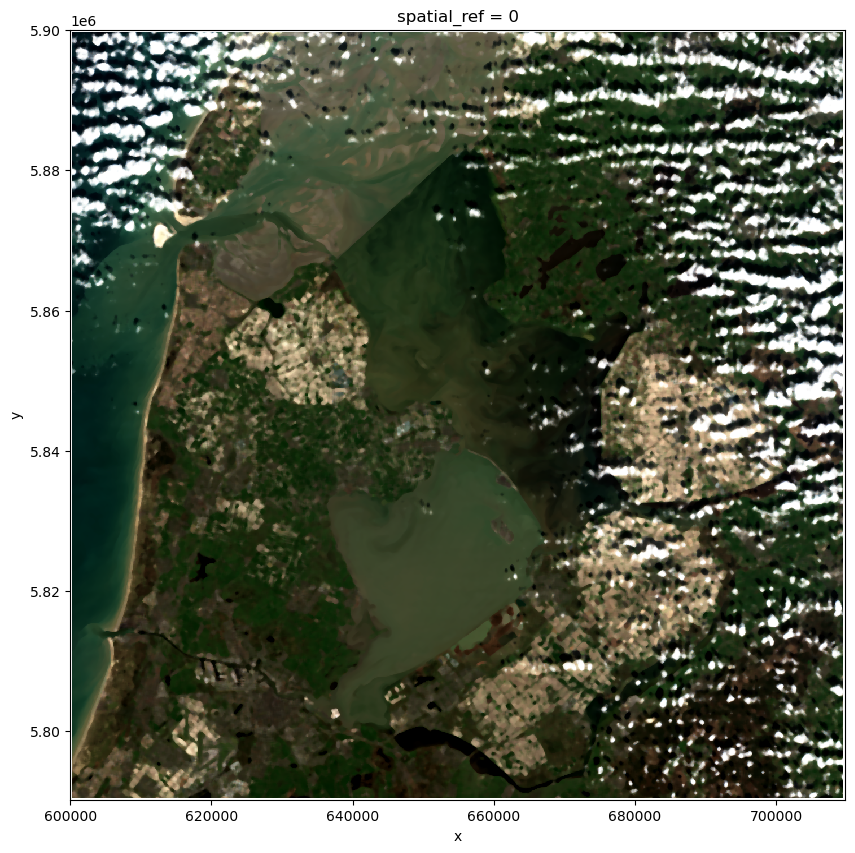

In [18]:
median_dask.plot.imshow(robust=True, figsize=(10,10))

In [24]:
# Saving the data to disk
from threading import Lock
median_dask.rio.to_raster("visual_median-filter-dask.tif", tiled= True, lock=Lock())